In [2]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from project.ship import Ship
from project.tests import Tests
from project.botma import TMA
import time
from pathlib import Path
from datetime import datetime
import ast

In [33]:
tests = Tests('test1')
print("Время последнего моделирования:", datetime.now().strftime("%d/%m/%Y %H:%M"))

# Создаем наблюдателя
observer_x, observer_y, observer_course, observer_velocity = 0, 0, 0, 5
observer = Ship('Наблюдатель', observer_x, observer_y, observer_course,
                observer_velocity, verbose=True)

# Моделирование траектории наблюдателя
observer.forward_movement(3 * 60)
observer.change_course(270, 'left', omega=0.5)
observer.forward_movement(5 * 60)
observer.change_course(90, 'right', omega=0.5)
observer.forward_movement(3 * 60)

Время последнего моделирования: 28/03/2021 20:05
Наблюдатель движется прямо по курсу 0.0° 180с
Наблюдатель перешёл на курс 270.0° за 180с
Наблюдатель движется прямо по курсу 270.0° 300с
Наблюдатель перешёл на курс 90.0° за 360с
Наблюдатель движется прямо по курсу 90.0° 180с


In [113]:
p0 = [0., 25., 90., 7.]
d_arr = [10., 20., 30., 40.]
std_arr = [0., 0.1, 0.2, 0.3, 0.5, 1.]
alg_arr = ['ММП v2', 'Метод N пеленгов']
def target_func(seed=None):
            rng = np.random.RandomState(seed)
            b = 0
            d = rng.uniform(5, 50)
            c = rng.uniform(0, 180)
            v = rng.uniform(3, 15)
            return [b, d, c, v]
result_df = pd.DataFrame(columns=['Algorithm', 'std', 'sr_0', 'sr_1', 'sr_2', 'sr_3', 'Ка', 'Nf', 'Nf_max', 'Iter', 'Iter_max', 't', 't_max'])
mean_columns = ['Ка', 'Nf', 'Iter', 't']
max_columns = ['Nf', 'Iter', 't']

In [46]:
%%time
tma = TMA(observer)
for std in std_arr:
    tma.standart_deviation = np.radians(std)
    for alg in alg_arr:
        dict_results = tma.swarm(algorithm_name=alg, n=10000, target_func=target_func, p0=p0, seeded=True)
        df = tests.get_df(dict_results)
        tests.save_df(df, name='../tests/test2/' + str(alg) + ' ' + str(std) + '.xlsx')
        res = pd.DataFrame({'Algorithm': [alg], 'std': [std]})
        for i in range(4):
            res['sr_' + str(i)] = [df['Успех'].apply(lambda x: x[i]).mean(axis=0)]
        res[mean_columns] = df[mean_columns].mean(axis=0)
        res[['Nf_max', 'Iter_max', 't_max']] = df[max_columns].apply(max, axis=0)
        result_df = result_df.append(res)

..\project\botma.py:184: RuntimeWarning: invalid value encountered in sqrt
  if (np.diag(res[1]) < 0).any():
Wall time: 55min 38s


In [47]:
result_df.reset_index(drop=True)
Path("../tests/test2").mkdir(parents=True, exist_ok=True)
tests.save_df(result_df, name='../tests/test2/results.xlsx')

In [61]:
result_df = pd.read_excel('../tests/test2/results.xlsx')
display_df = result_df.copy()
precisions = {'Ка' : '{0:.2f}', 'Nf' : '{0:.0f}', 'Nf_max': '{0:.0f}',\
'Iter' : '{0:.0f}', 'Iter_max' : '{0:.0f}', 't' : '{0:.4f}', 't_max' : '{0:.4f}'}
for col, precision in precisions.items():
    display_df[col] = display_df[col].apply(lambda x: precision.format(x))

In [62]:
display_df

,Algorithm,std,sr_0,sr_1,sr_2,sr_3,Ка,Nf,Nf_max,Iter,Iter_max,t,t_max
0,ММП v2,0.0,0.9999,0.9999,0.9999,0.9999,0.08,10,51,9,36,0.0021,0.0083
1,Метод N пеленгов,0.0,1.0000,1.0000,1.0000,1.0000,0.00,nan,nan,nan,nan,0.0002,0.0030
2,ММП v2,0.1,0.9418,0.9828,0.9828,0.9924,0.09,10,54,9,38,0.0021,0.0148
3,Метод N пеленгов,0.1,0.5602,0.7582,0.7592,0.8478,0.01,nan,nan,nan,nan,0.0002,0.0012
4,ММП v2,0.2,0.8619,0.9417,0.9417,0.9677,0.12,10,60,9,42,0.0021,0.0109
5,Метод N пеленгов,0.2,0.3067,0.5167,0.5240,0.6141,0.05,nan,nan,nan,nan,0.0002,0.0008
6,ММП v2,0.3,0.7819,0.8998,0.8999,0.9363,0.17,10,57,9,40,0.0021,0.0100
7,Метод N пеленгов,0.3,0.1887,0.3514,0.3579,0.4422,0.11,nan,nan,nan,nan,0.0002,0.0007
8,ММП v2,0.5,0.6355,0.8220,0.8230,0.8770,0.33,10,55,9,39,0.0021,0.0096
9,Метод N пеленгов,0.5,0.0485,0.1462,0.1481,0.2284,0.38,nan,nan,nan,nan,0.0002,0.0027


In [69]:
lm01 = pd.read_excel('../tests/test2/ММП v2 0.1.xlsx')
lm02 = pd.read_excel('../tests/test2/ММП v2 0.2.xlsx')

In [68]:
lm01[lm01['Ка'] > 1]

,П0_ист,Д0_ист,К0_ист,V0_ист,П0_расч,Д0_расч,К0_расч,V0_расч,П0_апр,Д0_апр,...,СКО X,СКО Y,СКО VX,СКО VY,Ка,Кб,Успех,t,Nf,Iter
8145,0,5.311878,95.784375,13.841782,77.759786,28.386229,263.289218,24.25903,0,25,...,0.003917,0.000243,0.002253,0.000152,829.035226,7.76905,"[0, 0, 0, 0]",0.009536,54,38


In [70]:
lm02[lm02['Ка'] > 1]

,П0_ист,Д0_ист,К0_ист,V0_ист,П0_расч,Д0_расч,К0_расч,V0_расч,П0_апр,Д0_апр,...,СКО X,СКО Y,СКО VX,СКО VY,Ка,Кб,Успех,t,Nf,Iter
8145,0,5.311878,95.784375,13.841782,77.618306,28.277999,263.172508,24.16363,0,25,...,NaN,NaN,NaN,NaN,824.39033,7.785945,"[0, 0, 0, 0]",0.010854,60,42


Аномалия для 8145 модели, пересчитаем сводку без неё

In [115]:
%%time
tma = TMA(observer)
for std in std_arr:
    tma.standart_deviation = np.radians(std)
    for alg in alg_arr:
        df = pd.read_excel('../tests/test2/' + str(alg) + ' ' + str(std) + '.xlsx')
        df = df[df['Ка'] < 10]
        res = pd.DataFrame({'Algorithm': [alg], 'std': [std]})
        for i in range(4):
            res['sr_' + str(i)] = [df['Успех'].apply(lambda x: ast.literal_eval(x)[i]).mean()]
        res[mean_columns] = df[mean_columns].mean(axis=0)
        res[['Nf_max', 'Iter_max', 't_max']] = df[max_columns].apply(max, axis=0)
        result_df = result_df.append(res)

Wall time: 1min 6s


In [117]:
result_df.reset_index(drop=True)
Path("../tests/test2").mkdir(parents=True, exist_ok=True)
tests.save_df(result_df, name='../tests/test2/results.xlsx')

In [3]:
result_df = pd.read_excel('../tests/test2/results.xlsx')
result_df['Ка'] = result_df['Ка'].apply(np.sqrt)
result_df.rename(columns={'std': 'СКО', 'Algorithm': 'Алгоритм'}, inplace=True)
result_df['Алгоритм'].replace({'ММП v2': 'ЛМ', 'Метод N пеленгов': 'N'}, inplace=True)
display_df = result_df.copy()
precisions = {'Ка' : '{0:.2f}', 'Nf' : '{0:.0f}', 'Nf_max': '{0:.0f}',\
'Iter' : '{0:.0f}', 'Iter_max' : '{0:.0f}', 't' : '{0:.4f}', 't_max' : '{0:.4f}'}
for col, precision in precisions.items():
    display_df[col] = display_df[col].apply(lambda x: precision.format(x))

In [4]:
print('Сводная таблица:')
display_df

Сводная таблица:


,Алгоритм,СКО,sr_0,sr_1,sr_2,sr_3,Ка,Nf,Nf_max,Iter,Iter_max,t,t_max
0,ЛМ,0.0,1.000000,1.000000,1.000000,1.000000,0.00,10,41,9,29,0.0021,0.0075
1,N,0.0,1.000000,1.000000,1.000000,1.000000,0.00,nan,nan,nan,nan,0.0002,0.0030
2,ЛМ,0.1,0.941894,0.982898,0.982898,0.992499,0.10,10,41,9,29,0.0021,0.0148
3,N,0.1,0.560200,0.758200,0.759200,0.847800,0.11,nan,nan,nan,nan,0.0002,0.0012
4,ЛМ,0.2,0.861986,0.941794,0.941794,0.967797,0.20,10,41,9,29,0.0021,0.0070
5,N,0.2,0.306700,0.516700,0.524000,0.614100,0.21,nan,nan,nan,nan,0.0002,0.0008
6,ЛМ,0.3,0.781978,0.899890,0.899990,0.936394,0.30,10,42,9,30,0.0021,0.0075
7,N,0.3,0.188700,0.351400,0.357900,0.442200,0.33,nan,nan,nan,nan,0.0002,0.0007
8,ЛМ,0.5,0.635564,0.822082,0.823082,0.877088,0.50,10,42,9,29,0.0021,0.0071
9,N,0.5,0.048505,0.146215,0.148115,0.228423,0.61,nan,nan,nan,nan,0.0002,0.0027


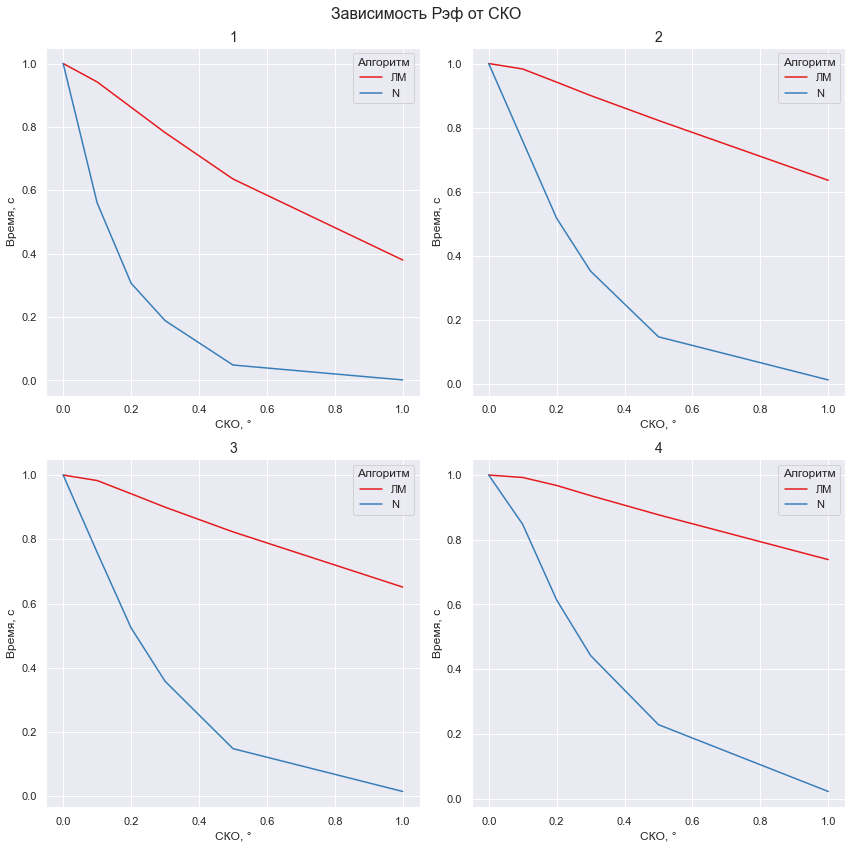

In [143]:
num_rows, num_cols = 2, 2
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 12))
f.suptitle('Зависимость Рэф от СКО', fontsize=16)

for index, column in enumerate(['sr_0', 'sr_1', 'sr_2', 'sr_3']):
    i,j = (index // num_cols, index % num_cols)
    ax = sns.lineplot(data=result_df, x='СКО', y=column, hue='Алгоритм', palette='Set1', ax=axes[i, j])
    ax.set_title(index+1, fontsize=14)
    ax.set_ylabel('Время, с', fontsize=12)
    ax.set_xlabel('CКО, °', fontsize=12)


plt.tight_layout()
plt.show()

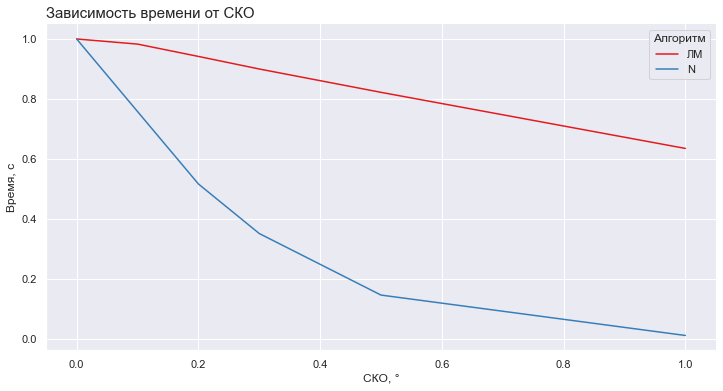

In [103]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=result_df, x='СКО', y='sr_1', hue='Алгоритм', palette='Set1')
ax.set_title('Зависимость времени от СКО', fontsize=15, loc='left')
plt.ylabel('Время, с', fontsize=12)
plt.xlabel('CКО, °', fontsize=12)
sns.axes_style('darkgrid')
sns.despine()

Можно сделать вывод, что алгоритм зависит только от "геометрии" минимизируемой функции.

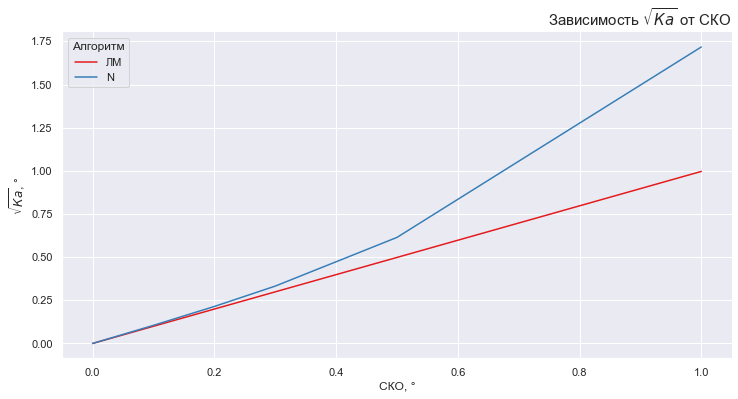

In [111]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=result_df, x='СКО', y='Ка', hue='Алгоритм', palette='Set1', markers= "o");
ax.set_title('Зависимость $\sqrt{Ка}$ от СКО', fontsize=15, loc='right')
plt.ylabel('$\sqrt{Ка}$, °', fontsize=12)
plt.xlabel('CКО, °', fontsize=12)
sns.axes_style('darkgrid')
sns.despine()